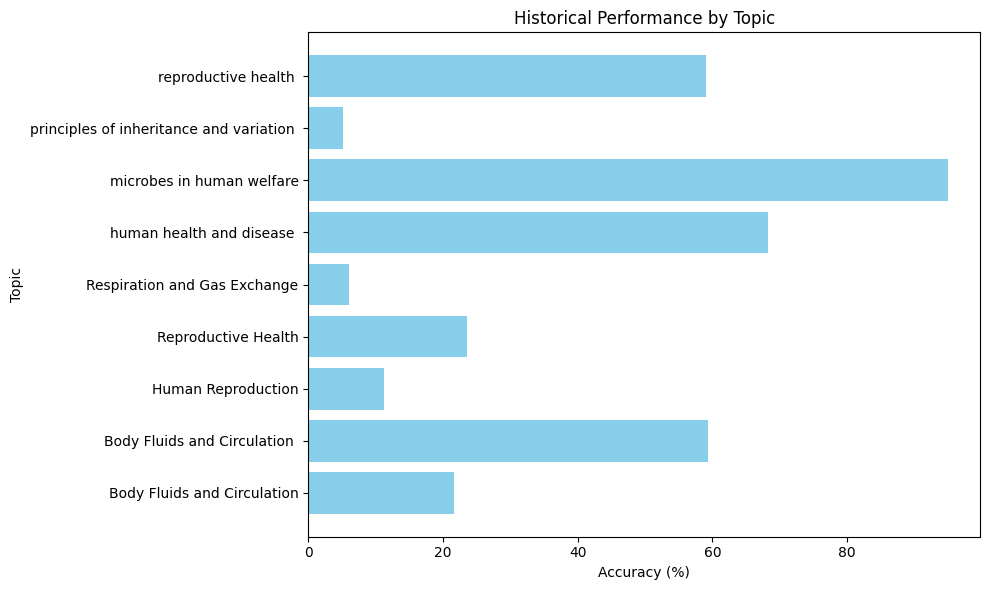

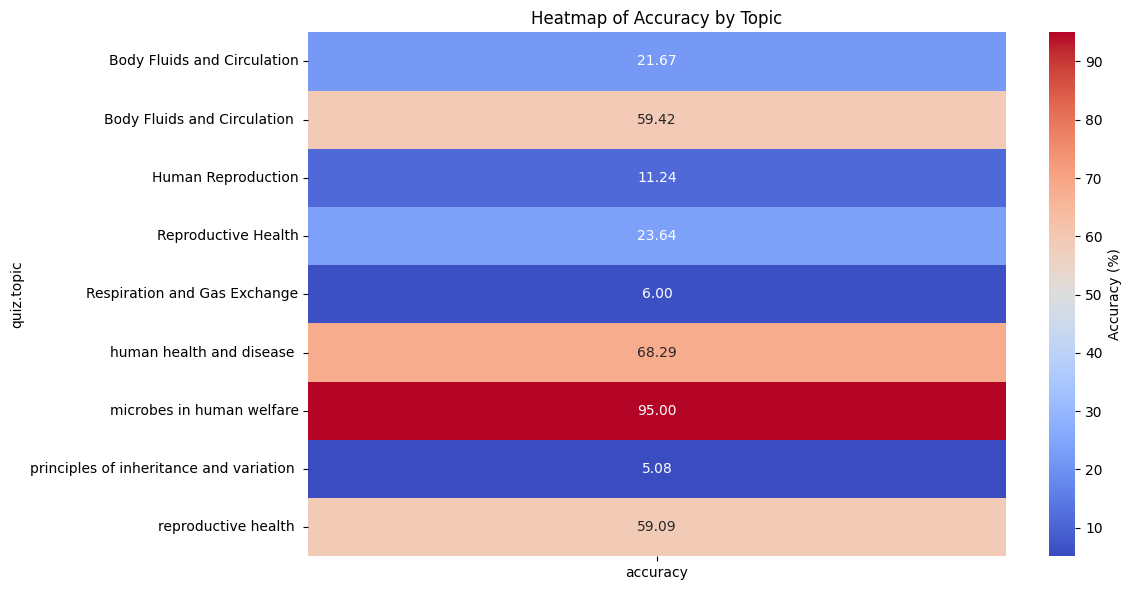

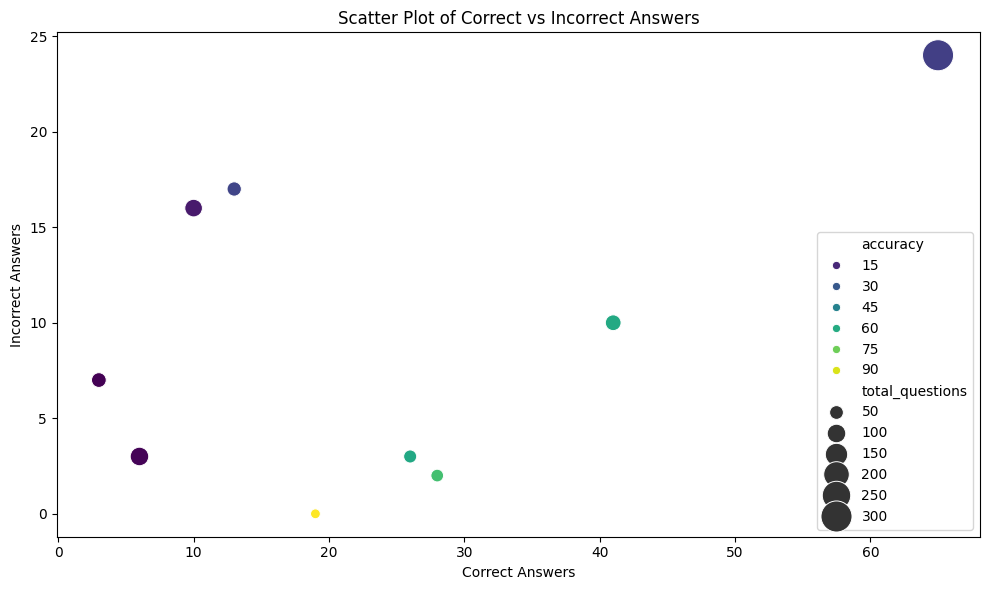


 Historical Performance by Topic
                                 quiz.topic  correct_answers  \
0               Body Fluids and Circulation               65   
1              Body Fluids and Circulation                41   
2                        Human Reproduction               10   
3                       Reproductive Health               13   
4              Respiration and Gas Exchange                6   
5                 human health and disease                28   
6                 microbes in human welfare               19   
7  principles of inheritance and variation                 3   
8                      reproductive health                26   

   incorrect_answers  total_questions   accuracy  
0                 24              300  21.666667  
1                 10               69  59.420290  
2                 16               89  11.235955  
3                 17               55  23.636364  
4                  3              100   6.000000  
5                  

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
from collections import Counter

QUIZ_URL = "https://www.jsonkeeper.com/b/LLQT"
SUBMISSION_URL = "https://api.jsonserve.com/rJvd7g"
HISTORY_URL = "https://api.jsonserve.com/XgAgFJ"


def fetch_json(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

quiz_data = fetch_json(QUIZ_URL)
submission_data = fetch_json(SUBMISSION_URL)
history_data = fetch_json(HISTORY_URL)


quiz_df = pd.json_normalize(quiz_data['quiz']['questions'])
submission_df = pd.json_normalize(submission_data)
history_df = pd.json_normalize(history_data)


def calculate_accuracy(correct, total):
    return (correct / total) * 100 if total > 0 else 0


def analyze_historical_performance(history_df):
    performance_summary = history_df.groupby("quiz.topic").agg({
        "correct_answers": "sum",
        "incorrect_answers": "sum",
        "total_questions": "sum"
    }).reset_index()
    performance_summary["accuracy"] = performance_summary.apply(
        lambda row: calculate_accuracy(row.correct_answers, row.total_questions), axis=1
    )
    return performance_summary

historical_performance = analyze_historical_performance(history_df)


plt.figure(figsize=(10, 6))
plt.barh(historical_performance["quiz.topic"], historical_performance["accuracy"], color="skyblue")
plt.xlabel("Accuracy (%)")
plt.ylabel("Topic")
plt.title("Historical Performance by Topic")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
heatmap_data = historical_performance.set_index("quiz.topic")[["accuracy"]]
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Accuracy (%)'})
plt.title("Heatmap of Accuracy by Topic")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=historical_performance,
    x="correct_answers",
    y="incorrect_answers",
    hue="accuracy",
    size="total_questions",
    sizes=(50, 500),
    palette="viridis",
    legend=True
)
plt.xlabel("Correct Answers")
plt.ylabel("Incorrect Answers")
plt.title("Scatter Plot of Correct vs Incorrect Answers")
plt.tight_layout()
plt.show()


def find_weak_areas(historical_performance, threshold=70):
    weak_topics = historical_performance[historical_performance["accuracy"] < threshold]
    return weak_topics

weak_areas = find_weak_areas(historical_performance)


def generate_recommendations(weak_areas):
    recommendations = []
    for _, row in weak_areas.iterrows():
        recommendations.append(f"Focus on the topic '{row['quiz.topic']}' with an accuracy of {row['accuracy']:.2f}%.")
    return recommendations

recommendations = generate_recommendations(weak_areas)


def define_student_persona(history_df):
    avg_accuracy = history_df["accuracy"].str.rstrip(" %").astype(float).mean()
    avg_speed = history_df["speed"].astype(float).mean()
    strong_topics = historical_performance[historical_performance["accuracy"] >= 90]
    weak_topics = historical_performance[historical_performance["accuracy"] < 70]

    persona = {
        "average_accuracy": avg_accuracy,
        "average_speed": avg_speed,
        "strong_topics": strong_topics["quiz.topic"].tolist(),
        "weak_topics": weak_topics["quiz.topic"].tolist()
    }
    return persona

student_persona = define_student_persona(history_df)


print("\n Historical Performance by Topic")
print(historical_performance)

print("\n Weak Areas ")
print(weak_areas)

print("\n Recommendations ")
for rec in recommendations:
    print(rec)

print("\n Student Persona ")
print(json.dumps(student_persona, indent=4))


